In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

#plt.style.use('seaborn-white')
plt.style.use('seaborn-whitegrid')
#sns.set_style('whitegrid')

In [2]:
hlimit = 100

pcsp_max_hex = 'FFF800000000'
pcsp_max_decimal = int(pcsp_max_hex,16)

tmax1 = hlimit
tmin1 = 1
x11 = tmax1 - tmin1

rbamax1 = pcsp_max_decimal
rbamin1 = 1
d11 = rbamax1 - rbamin1

pcsp_max_scaled = np.around((((rbamax1 - rbamin1) * x11) / d11) + tmin1, 2)

print(pcsp_max_hex,pcsp_max_decimal,pcsp_max_scaled )

FFF800000000 281440616972288 100.0


In [3]:
df_pcsp = pd.read_excel('My_scheduled_job_data and others.xlsx',sheet_name='sheet1')

In [4]:
df_pcsp['RBA_Decimal'] = df_pcsp['endrba'].apply(lambda x: int(x,16))
df_pcsp['Date1'] = df_pcsp['Timestamp'].apply(lambda x: str(x))
df_pcsp['Date1YY'] = df_pcsp['Date1'].str.slice(stop=4) 
df_pcsp['Date1MM'] = df_pcsp['Date1'].str.slice(start=5,stop=7) 
df_pcsp['Date1DD'] = df_pcsp['Date1'].str.slice(start=8,stop=10) 
df_pcsp['Time1hh'] = df_pcsp['Date1'].str.slice(start=11,stop=13) 
df_pcsp['Time1mm'] = df_pcsp['Date1'].str.slice(start=14,stop=16) 
df_pcsp['Time1ss'] = df_pcsp['Date1'].str.slice(start=17,stop=19)
df_pcsp['Time1nn'] = df_pcsp['Date1'].str.slice(start=20,stop=26)
df_pcsp['DateTime'] = df_pcsp['Date1YY'] + '-' +  df_pcsp['Date1MM'] + '-' + df_pcsp['Date1DD'] + ' ' + df_pcsp['Time1hh'] + ':' + df_pcsp['Time1mm'] + ':' + df_pcsp['Time1ss'] + '.' + df_pcsp['Time1nn']

df_pcsp['DateTime'] = pd.to_datetime(df_pcsp['DateTime'],format='%Y-%m-%d %H:%M:%S.%f')
df_pcsp.drop(['Timestamp', 'Date1', 'Date1YY', 'Date1MM', 'Date1DD','Time1hh', 'Time1mm', 'Time1ss', 'Time1nn'], axis=1, inplace=True)

In [5]:
tmax1 = hlimit
tmin1 = 1
x11 = tmax1 - tmin1

rbamax1 = pcsp_max_decimal 
#np.max(df_pcsp['RBA_Decimal'])
rbamin1 = np.min(df_pcsp['RBA_Decimal'])
d11 = rbamax1 - rbamin1

df_pcsp['RBA_Decimal_scaled'] = np.around((((df_pcsp['RBA_Decimal'] - rbamin1) * x11) / d11) + tmin1, 5)

In [6]:
df_pcsp['RBA_limit'] = pcsp_max_scaled

In [7]:
df_pcsp.head(10)

,endrba,RBA_Decimal,DateTime,RBA_Decimal_scaled,RBA_limit
0,F36E95A090E8,267656282280168,2019-04-12 11:39:24.760534,1.00000,100.0
1,F36E96EC53B0,267656304022448,2019-04-12 11:42:37.195318,1.00016,100.0
2,F36F14DDD0D2,267658417000658,2019-04-12 15:13:32.385424,1.01533,100.0
3,F36F1E23CBF3,267658572581875,2019-04-12 15:30:02.531634,1.01645,100.0
4,F36F26C33D46,267658717248838,2019-04-12 15:45:04.757484,1.01749,100.0
5,F36F2C6B04B8,267658812130488,2019-04-12 16:00:04.620454,1.01817,100.0
6,F36F42A829E5,267659185236453,2019-04-12 16:42:11.899448,1.02085,100.0
7,F36F5DECC8BA,267659642718394,2019-04-12 17:20:25.551111,1.02413,100.0
8,F36F6078F2FC,267659685458684,2019-04-12 17:30:03.536977,1.02444,100.0
9,F36F64F7269C,267659760838300,2019-04-12 17:45:03.829224,1.02498,100.0


In [8]:
df_pcsp.tail(10)

,endrba,RBA_Decimal,DateTime,RBA_Decimal_scaled,RBA_limit
6512,F67A2971578A,271004541736842,2019-06-21 07:16:00.223519,25.04742,100.0
6513,F67A54A6DD96,271005266664854,2019-06-21 07:31:01.339395,25.05263,100.0
6514,F67A66449419,271005562213401,2019-06-21 07:46:01.298642,25.05475,100.0
6515,F67AADEF4E6C,271006764584556,2019-06-21 08:01:00.546067,25.06338,100.0
6516,F67AC4591DBA,271007140617658,2019-06-21 08:16:00.277833,25.06609,100.0
6517,F67ADA2DDD27,271007506881831,2019-06-21 08:31:00.596386,25.06872,100.0
6518,F67AE6D4A537,271007719138615,2019-06-21 08:46:01.427868,25.07024,100.0
6519,F67AFA03195C,271008040950108,2019-06-21 09:01:02.559627,25.07255,100.0
6520,F67B072B2034,271008261677108,2019-06-21 09:16:00.207868,25.07414,100.0
6521,F67B17EBBB06,271008542735110,2019-06-21 09:31:01.037918,25.07616,100.0


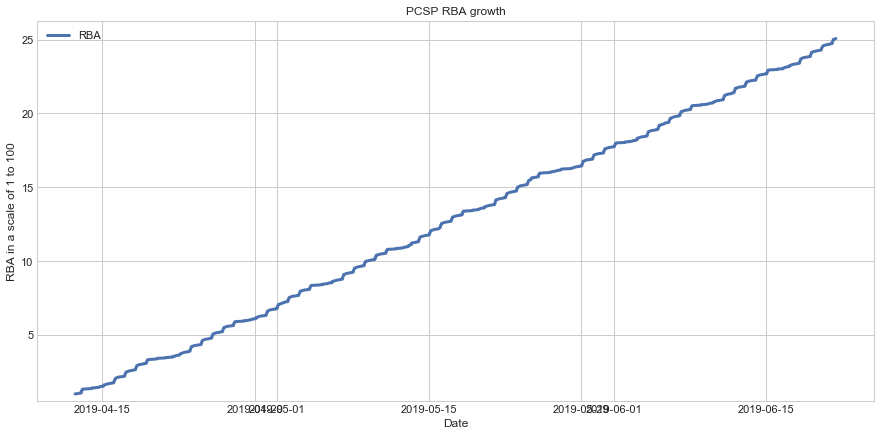

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(df_pcsp['DateTime'], df_pcsp['RBA_Decimal_scaled'],  c= 'b' ,label = 'RBA', linewidth=3.0)
plt.ylim(.5)

plt.title('PCSP RBA growth')
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('RBA in a scale of 1 to 100')

plt.grid(True)
plt.savefig('HAMPCSP_RBA_growth.jpg')
plt.show()


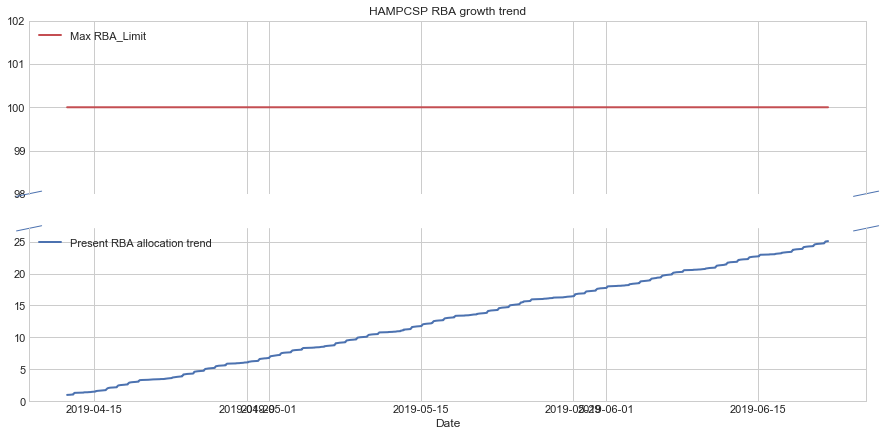

In [10]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharex=True)

ax.plot(df_pcsp['DateTime'], df_pcsp['RBA_limit'], c= 'r' , label = 'Max RBA_Limit', linewidth=2.0)
ax.set_title('HAMPCSP RBA growth trend' )
ax.legend(loc="upper left")
ax.set_ylabel = 'RBA'


ax2.plot(df_pcsp['DateTime'], df_pcsp['RBA_Decimal_scaled'], c= 'b' ,label = 'Present RBA allocation trend', linewidth=2.0)
ax2.legend(loc="upper left")

ax.set_ylim(np.max(df_pcsp['RBA_limit']) - 2, np.max(df_pcsp['RBA_limit']) + 2  )           # outliers only
#ax2.set_ylim(np.min(df_pcsp['RBA_Decimal_scaled']), np.max(df_pcsp['RBA_Decimal_scaled']) + 2)  # most of the data

ax2.set_ylim(0, np.max(df_pcsp['RBA_Decimal_scaled']) + 2)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates

kwargs = dict(transform=ax.transAxes, color='b', clip_on=False, linewidth=1.0)

ax.plot((-d, +d), (-d, +d), **kwargs)                    # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)              # top-right diagonal

kwargs.update(transform=ax2.transAxes)                   # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)             # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)       # bottom-right diagonal


plt.legend(loc="upper left")
plt.grid(True)
plt.xlabel('Date')
plt.savefig('HAMPCSP_RBA_growth_trend.jpg')
plt.show()



In [11]:
def lagrow (series, window):
    start = 0
    start_value = 0
    end_value  = window
    
    list_moving_average = []
    for i in range(window):
        initial_value = 0
        list_moving_average.append(initial_value)
        
    l = len(series)
    
    for j in range(l - window):
         list_moving_average.append(series[j])
    return list_moving_average

In [12]:
windows = 1
df_pcsp['RBA_lag1'] = lagrow(df_pcsp['RBA_Decimal'], windows)

df_pcsp['RBA_diff'] = df_pcsp['RBA_Decimal'] - df_pcsp['RBA_lag1']

df_pcsp.drop(df_pcsp.index[0], inplace=True)

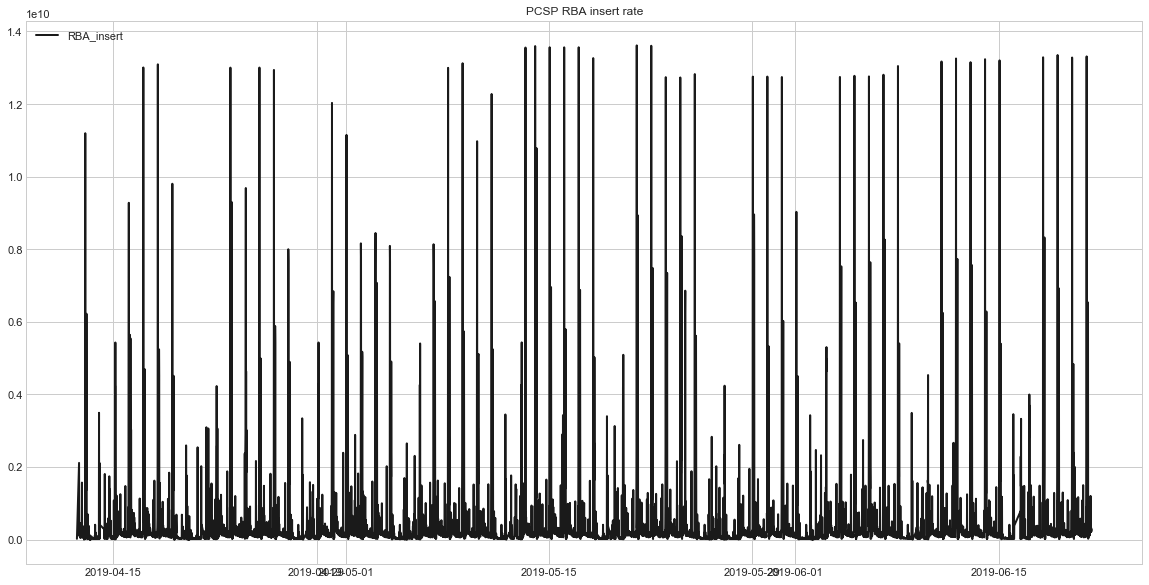

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(df_pcsp['DateTime'],df_pcsp['RBA_diff'], c= 'k' ,label = 'RBA_insert', linewidth=2.0)

plt.title('PCSP RBA insert rate')
plt.legend(loc="upper left")

plt.grid(True)
plt.savefig('HAMPCSP_RBA_insert_rate.jpg')
plt.show()

In [14]:
df_pcsp.tail()

,endrba,RBA_Decimal,DateTime,RBA_Decimal_scaled,RBA_limit,RBA_lag1,RBA_diff
6517,F67ADA2DDD27,271007506881831,2019-06-21 08:31:00.596386,25.06872,100.0,271007140617658,366264173
6518,F67AE6D4A537,271007719138615,2019-06-21 08:46:01.427868,25.07024,100.0,271007506881831,212256784
6519,F67AFA03195C,271008040950108,2019-06-21 09:01:02.559627,25.07255,100.0,271007719138615,321811493
6520,F67B072B2034,271008261677108,2019-06-21 09:16:00.207868,25.07414,100.0,271008040950108,220727000
6521,F67B17EBBB06,271008542735110,2019-06-21 09:31:01.037918,25.07616,100.0,271008261677108,281058002


In [15]:
df_pcsp_01 = df_pcsp[['DateTime', 'endrba', 'RBA_Decimal', 'RBA_diff']].copy()
df_pcsp_01.to_csv('My_scheduled_job_data and others_after_execution.csv', index=False)

In [16]:
df_week01 = df_pcsp[(df_pcsp['DateTime'] >= '2019-04-14 00:00:00.000000000') &  (df_pcsp['DateTime'] <= '2019-04-20 23:59:59.000000000')].copy(deep = True)

In [17]:
df_week01.head()

,endrba,RBA_Decimal,DateTime,RBA_Decimal_scaled,RBA_limit,RBA_lag1,RBA_diff
134,F37A58010669,267706788021865,2019-04-14 00:01:00.880992,1.36274,100.0,267706753891053,34130812
135,F37B283AED28,267710281477416,2019-04-14 00:16:02.318629,1.38783,100.0,267706788021865,3493455551
136,F37B34585174,267710484730228,2019-04-14 00:31:00.200511,1.38929,100.0,267710281477416,203252812
137,F37B35E119FC,267710510471676,2019-04-14 00:46:00.490429,1.38947,100.0,267710484730228,25741448
138,F37B39A74000,267710573789184,2019-04-14 01:01:00.622752,1.38993,100.0,267710510471676,63317508


In [18]:
df_week01.tail()

,endrba,RBA_Decimal,DateTime,RBA_Decimal_scaled,RBA_limit,RBA_lag1,RBA_diff
775,F3BE64791CB9,267999054994617,2019-04-20 22:46:00.357225,3.46182,100.0,267999029592592,25402025
776,F3BE690649D6,267999131355606,2019-04-20 23:01:00.266954,3.46236,100.0,267999054994617,76360989
777,F3BE6B257000,267999166951424,2019-04-20 23:16:01.305357,3.46262,100.0,267999131355606,35595818
778,F3BE6CFEC000,267999197970432,2019-04-20 23:31:00.287094,3.46284,100.0,267999166951424,31019008
779,F3BE6EBAB68C,267999227065996,2019-04-20 23:46:00.566225,3.46305,100.0,267999197970432,29095564


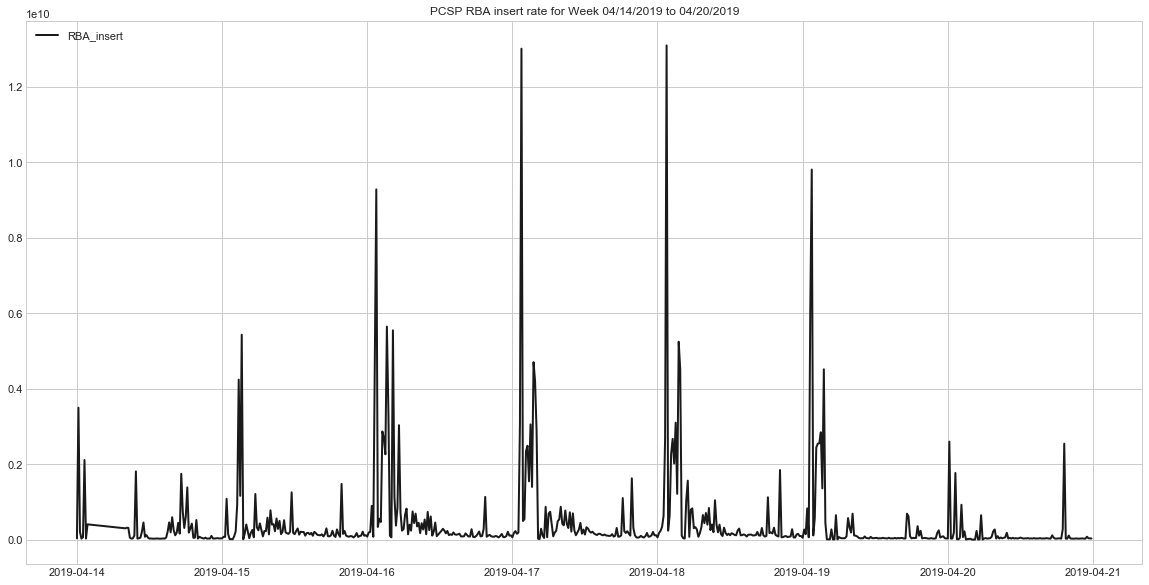

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(df_week01['DateTime'],df_week01['RBA_diff'], c= 'k' ,label = 'RBA_insert', linewidth=2.0)

plt.title('PCSP RBA insert rate for Week 04/14/2019 to 04/20/2019')
plt.legend(loc="upper left")

plt.grid(True)
plt.show()

In [20]:
df_week02 = df_pcsp[(df_pcsp['DateTime'] >= '2019-04-21 00:00:00.000000000') &  (df_pcsp['DateTime'] <= '2019-04-27 23:59:59.000000000')].copy(deep = True)

In [21]:
df_week02.head()

,endrba,RBA_Decimal,DateTime,RBA_Decimal_scaled,RBA_limit,RBA_lag1,RBA_diff
780,F3BE712B0E05,267999267982853,2019-04-21 00:01:00.637387,3.46335,100.0,267999227065996,40916857
781,F3BE7528F000,267999334952960,2019-04-21 00:16:00.458669,3.46383,100.0,267999267982853,66970107
782,F3BE7794CCB9,267999375576249,2019-04-21 00:31:00.406418,3.46412,100.0,267999334952960,40623289
783,F3BE791650D2,267999400841426,2019-04-21 00:46:01.046488,3.46430,100.0,267999375576249,25265177
784,F3BE7CDB29CA,267999464073674,2019-04-21 01:01:00.442613,3.46475,100.0,267999400841426,63232248


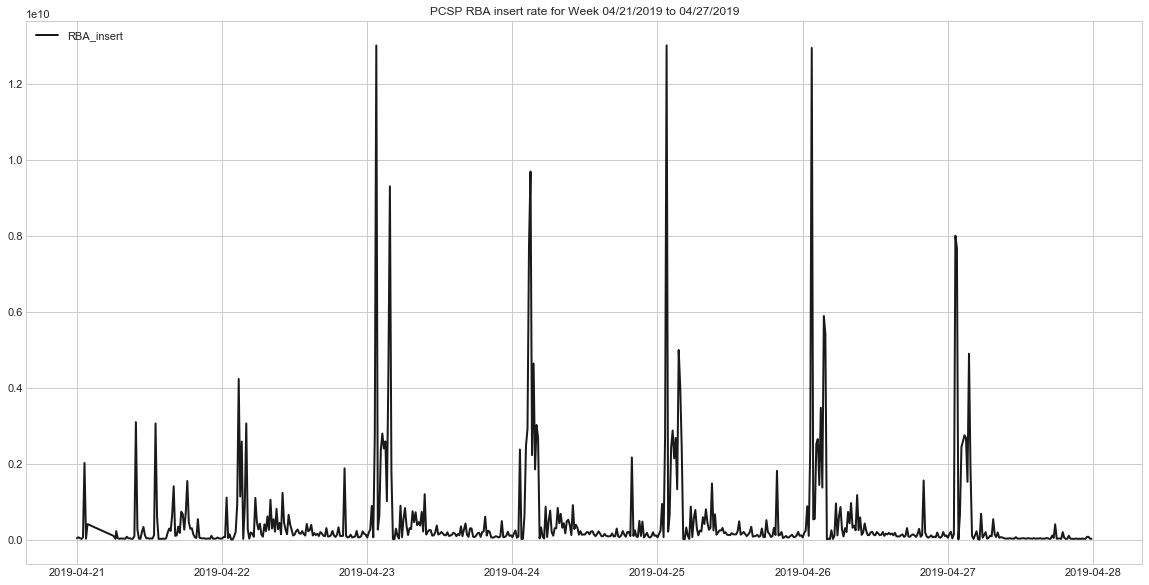

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(df_week02['DateTime'],df_week02['RBA_diff'], c= 'k' ,label = 'RBA_insert', linewidth=2.0)

plt.title('PCSP RBA insert rate for Week 04/21/2019 to 04/27/2019')
plt.legend(loc="upper left")

plt.grid(True)
plt.show()

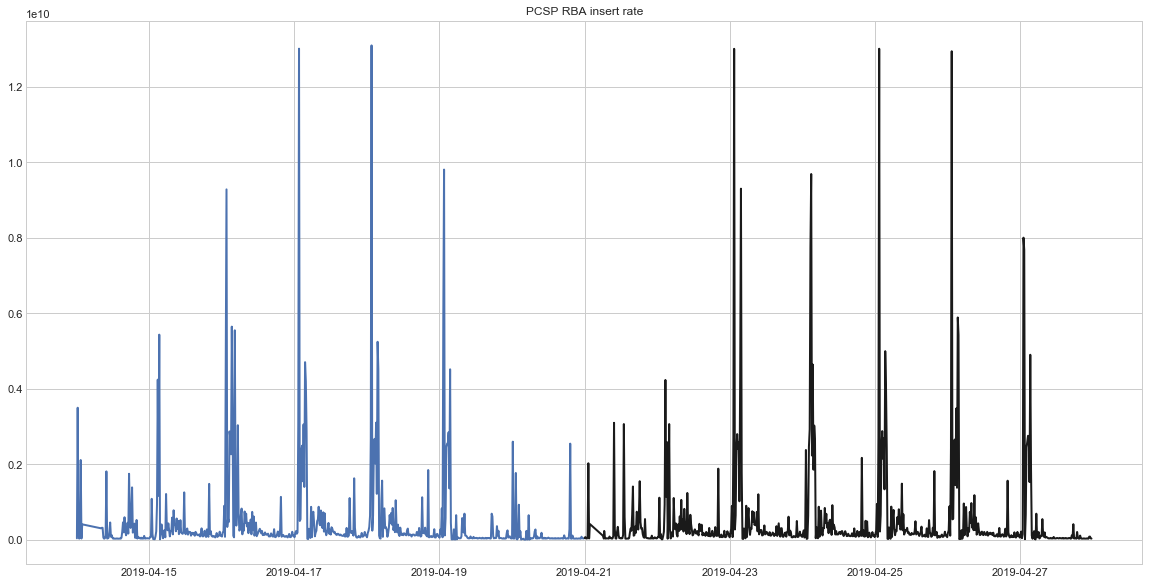

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(df_week01['DateTime'],df_week01['RBA_diff'], c= 'b' ,label = 'RBA_insert', linewidth=2.0)
plt.plot(df_week02['DateTime'],df_week02['RBA_diff'], c= 'k' ,label = 'RBA_insert', linewidth=2.0)

plt.title('PCSP RBA insert rate')
#plt.legend(loc="upper left")

plt.grid(True)
plt.show()